# Tuning free ridge regression with conformal prediction

This notebook illustrates how we obtained Figure 2 of our paper: [https://arxiv.org/abs/2104.13871](https://arxiv.org/abs/2104.13871). To save users' computation time we ran the data generating code in advance and save them as RData file under the same directory and explain here how we plotted the figure and what the plot means.

First we consider a linear model where each row of  $X$ is generated independently following a multivariate student distribution $t_d(\nu, \Sigma)$ with $d \times d$ covariance matrix $\Sigma$ satisfying $\Sigma_{ij}=\rho = 0.5$ if $i \neq j$ (equi correlation) and $\Sigma_{jj}=1$.
$Y$ is generated from 

\begin{align}
 Y=X \beta + \xi, \text{ where }\beta_j=1+(j-1)\mbox{ mod }5, 1 \leq j \leq d, \label{eq:linear_fm}\tag{1}
\end{align}

and the coordinates of $\xi$ are independently generated from $t(\nu) \times (1+ \sqrt{ X_1^2+X_2^2})$, conditional on $X$. Note that irrespective of the dimension, the conditional variance of $\xi$ depends only on the first two covariates. The degrees of freedom is $\nu=3$ in the first experiment and $\nu=5$ for the second one. Note that (\ref{eq:linear_fm}) is a well-specified model but with heteroscedastic noise.

In [149]:
library(glmnet)
library(MASS)
library(mvtnorm)
source("ridge_funs.R")
name=paste("linear_fm_t3",sep="")


df <- 3  #degrees of freedom
l <- 60    #number of dimensions 
l.lambda <- 100
lambda_seq <- seq(0,200,l=l.lambda)
dim <- round(seq(5,300,l=l))
alpha <- 0.1
n <- 200   #number of training samples
n0 <- 100  #number of prediction points
nrep <- 100 #number of independent trials
rho <- 0.5

cov.efcp <- len.efcp <- matrix(0,nrep,l)
cov.vfcp <- len.vfcp <- matrix(0,nrep,l)
cov.naive <- len.naive <- matrix(0,nrep,l)
cov.param <- len.param <- matrix(0,nrep,l)
cov.star <- len.star <- matrix(0,nrep,l)
cov.cv10 <- len.cv10 <- matrix(0,nrep,l)
cov.cv5 <- len.cv5 <- matrix(0,nrep,l)
cov.cvloo <- len.cvloo <- matrix(0,nrep,l)


out.efcp.up <- out.efcp.lo <- matrix(0,n0,l)
out.vfcp.up <- out.vfcp.lo <- matrix(0,n0,l)
out.naive.up <- out.naive.lo <- matrix(0,n0,l)
out.param.up <- out.param.lo <- matrix(0,n0,l)
out.star.up <- out.star.lo <- matrix(0,n0,l)
out.cv10.up <- out.cv10.lo <- matrix(0,n0,l)
out.cv5.up <- out.cv5.lo <- matrix(0,n0,l)
out.cvloo.up <- out.cvloo.lo <- matrix(0,n0,l)


for(i in 1:nrep){
  if(i%%10 == 0){
    print(i)
  }
  for (r in 1:l){
    d <- dim[r]
    set.seed(i)
    
    Sigma <- matrix(rho,d,d)
    diag(Sigma) <- rep(1,d)
    X <- rmvt(n,Sigma,df)	#multivariate t distribution
    beta <- rep(1:5,d/5)
    eps <- rt(n,df)*(1+sqrt(X[,1]^2+X[,2]^2))
    Y <- X%*%beta+eps
    
    
    X0 <- rmvt(n0,Sigma,df)
    eps0 <- rt(n0,df)*(1+sqrt(X0[,1]^2+X0[,2]^2))
    Y0 <- X0%*%beta+eps0
    
    
    out.param <- ginverse.fun(X,Y,X0,alpha=alpha)
    out.param.lo[,r] <- out.param$lo
    out.param.up[,r] <- out.param$up    
    cov.param[i,r] <- mean(out.param.lo[,r] <= Y0 & Y0 <= out.param.up[,r]) 
    len.param[i,r] <- mean(out.param.up[,r]-out.param.lo[,r]) 
    
    
    out.efcp <- efcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.efcp.up[,r] <- out.efcp$up
    out.efcp.lo[,r] <- out.efcp$lo    
    cov.efcp[i,r] <- mean(out.efcp.lo[,r] <= Y0 & Y0 <= out.efcp.up[,r]) 
    len.efcp[i,r] <- mean(out.efcp.up[,r]-out.efcp.lo[,r]) 
    
    
    out.vfcp <- vfcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.vfcp.up[,r] <- out.vfcp$up
    out.vfcp.lo[,r] <- out.vfcp$lo    
    cov.vfcp[i,r] <- mean(out.vfcp.lo[,r] <= Y0 & Y0 <= out.vfcp.up[,r]) 
    len.vfcp[i,r] <- mean(out.vfcp.up[,r]-out.vfcp.lo[,r]) 
    
    out.naive <- naive.fun(X,Y,X0,alpha=alpha)
    out.naive.up[,r] <- out.naive$up
    out.naive.lo[,r] <- out.naive$lo    
    cov.naive[i,r] <- mean(out.naive.lo[,r] <= Y0 & Y0 <= out.naive.up[,r]) 
    len.naive[i,r] <- mean(out.naive.up[,r]-out.naive.lo[,r]) 
    
    
    out.star <- star.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.star.up[,r] <- out.star$up
    out.star.lo[,r] <- out.star$lo   
    cov.star[i,r] <- mean(out.star.lo[,r] <= Y0 & Y0 <= out.star.up[,r]) 
    len.star[i,r] <- mean(out.star.up[,r] - out.star.lo[,r]) 
    
    
    out.cv5 <- cv.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha,nfolds=5)
    out.cv5.up[,r] <- out.cv5$up
    out.cv5.lo[,r] <- out.cv5$lo    
    cov.cv5[i,r] <- mean(out.cv5.lo[,r] <= Y0 & Y0 <= out.cv5.up[,r]) 
    len.cv5[i,r] <- mean(out.cv5.up[,r] - out.cv5.lo[,r])
    
  }
}

df.cov <- data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))

df.len <- data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))

save(dim,cov.param, cov.naive, cov.vfcp, cov.star, cov.cv5, cov.efcp, file = "ridge_linear_cov100_t3.RData" )
save(dim,len.param, len.naive, len.vfcp, len.star, len.cv5, len.efcp, file = "ridge_linear_len100_t3.RData" )


In [2]:
name=paste("linear_fm_t5",sep="")


df <- 5  #degrees of freedom
l <- 60    #number of dimensions 
l.lambda <- 100
lambda_seq <- seq(0,200,l=l.lambda)
dim <- round(seq(5,300,l=l))
alpha <- 0.1
n <- 200   #number of training samples
n0 <- 100  #number of prediction points
nrep <- 100 #number of independent trials
rho <- 0.5

cov.efcp <- len.efcp <- matrix(0,nrep,l)
cov.vfcp <- len.vfcp <- matrix(0,nrep,l)
cov.naive <- len.naive <- matrix(0,nrep,l)
cov.param <- len.param <- matrix(0,nrep,l)
cov.star <- len.star <- matrix(0,nrep,l)
cov.cv10 <- len.cv10 <- matrix(0,nrep,l)
cov.cv5 <- len.cv5 <- matrix(0,nrep,l)
cov.cvloo <- len.cvloo <- matrix(0,nrep,l)


out.efcp.up <- out.efcp.lo <- matrix(0,n0,l)
out.vfcp.up <- out.vfcp.lo <- matrix(0,n0,l)
out.naive.up <- out.naive.lo <- matrix(0,n0,l)
out.param.up <- out.param.lo <- matrix(0,n0,l)
out.star.up <- out.star.lo <- matrix(0,n0,l)
out.cv10.up <- out.cv10.lo <- matrix(0,n0,l)
out.cv5.up <- out.cv5.lo <- matrix(0,n0,l)
out.cvloo.up <- out.cvloo.lo <- matrix(0,n0,l)


for(i in 1:nrep){
  for (r in 1:l){
    d <- dim[r]
    set.seed(i)
    
    Sigma <- matrix(rho,d,d)
    diag(Sigma) <- rep(1,d)
    X <- rmvt(n,Sigma,df)	#multivariate t distribution
    beta <- rep(1:5,d/5)
    eps <- rt(n,df)*(1+sqrt(X[,1]^2+X[,2]^2))
    Y <- X%*%beta+eps
    
    
    X0 <- rmvt(n0,Sigma,df)
    eps0 <- rt(n0,df)*(1+sqrt(X0[,1]^2+X0[,2]^2))
    Y0 <- X0%*%beta+eps0
    
    
    out.param <- ginverse.fun(X,Y,X0,alpha=alpha)
    out.param.lo[,r] <- out.param$lo
    out.param.up[,r] <- out.param$up    
    cov.param[i,r] <- mean(out.param.lo[,r] <= Y0 & Y0 <= out.param.up[,r]) 
    len.param[i,r] <- mean(out.param.up[,r]-out.param.lo[,r]) 
    
    
    out.efcp <- efcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.efcp.up[,r] <- out.efcp$up
    out.efcp.lo[,r] <- out.efcp$lo    
    cov.efcp[i,r] <- mean(out.efcp.lo[,r] <= Y0 & Y0 <= out.efcp.up[,r]) 
    len.efcp[i,r] <- mean(out.efcp.up[,r]-out.efcp.lo[,r]) 
    
    
    out.vfcp <- vfcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.vfcp.up[,r] <- out.vfcp$up
    out.vfcp.lo[,r] <- out.vfcp$lo    
    cov.vfcp[i,r] <- mean(out.vfcp.lo[,r] <= Y0 & Y0 <= out.vfcp.up[,r]) 
    len.vfcp[i,r] <- mean(out.vfcp.up[,r]-out.vfcp.lo[,r]) 
    
    out.naive <- naive.fun(X,Y,X0,alpha=alpha)
    out.naive.up[,r] <- out.naive$up
    out.naive.lo[,r] <- out.naive$lo    
    cov.naive[i,r] <- mean(out.naive.lo[,r] <= Y0 & Y0 <= out.naive.up[,r]) 
    len.naive[i,r] <- mean(out.naive.up[,r]-out.naive.lo[,r]) 
    
    
    out.star <- star.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.star.up[,r] <- out.star$up
    out.star.lo[,r] <- out.star$lo   
    cov.star[i,r] <- mean(out.star.lo[,r] <= Y0 & Y0 <= out.star.up[,r]) 
    len.star[i,r] <- mean(out.star.up[,r] - out.star.lo[,r]) 
    
    
    out.cv5 <- cv.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha,nfolds=5)
    out.cv5.up[,r] <- out.cv5$up
    out.cv5.lo[,r] <- out.cv5$lo    
    cov.cv5[i,r] <- mean(out.cv5.lo[,r] <= Y0 & Y0 <= out.cv5.up[,r]) 
    len.cv5[i,r] <- mean(out.cv5.up[,r] - out.cv5.lo[,r])
    
  }
}

df.cov <- data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))

df.len <- data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))

save(dim,cov.param, cov.naive, cov.vfcp, cov.star, cov.cv5, cov.efcp, file = "ridge_linear_cov100_t5.RData" )
save(dim,len.param, len.naive, len.vfcp, len.star, len.cv5, len.efcp, file = "ridge_linear_len100_t5.RData" )



1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


In [8]:
library(ggplot2)
load("ridge_linear_cov100_t3.RData")
load("ridge_linear_len100_t3.RData")

len.param = len.param/len.vfcp
len.naive = len.naive/len.vfcp
len.star = len.star/len.vfcp
len.cv5 = len.cv5/len.vfcp
len.efcp = len.efcp/len.vfcp
len.vfcp = len.vfcp/len.vfcp


df.cov3=data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))
df.cov3_sd=data.frame(dim,apply(cov.param,2,sd),apply(cov.naive,2,sd),apply(cov.vfcp,2,sd),apply(cov.star,2,sd),apply(cov.cv5,2,sd), apply(cov.efcp,2,sd))/sqrt(nrow(len.param))


df.len3=data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))
df.len3_sd=data.frame(dim,apply(len.param,2,sd),apply(len.naive,2,sd),apply(len.vfcp,2,sd),apply(len.star,2,sd),apply(len.cv5,2,sd), apply(len.efcp,2,sd))/sqrt(nrow(len.param))


load("ridge_linear_cov100_t5.RData")
load("ridge_linear_len100_t5.RData")

len.param = len.param/len.vfcp
len.naive = len.naive/len.vfcp
len.star = len.star/len.vfcp
len.cv5 = len.cv5/len.vfcp
len.efcp = len.efcp/len.vfcp
len.vfcp = len.vfcp/len.vfcp

df.cov5=data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))
df.cov5_sd=data.frame(dim,apply(cov.param,2,sd),apply(cov.naive,2,sd),apply(cov.vfcp,2,sd),apply(cov.star,2,sd),apply(cov.cv5,2,sd), apply(cov.efcp,2,sd))/sqrt(nrow(len.param))

df.len5=data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))
df.len5_sd=data.frame(dim,apply(len.param,2,sd),apply(len.naive,2,sd),apply(len.vfcp,2,sd),apply(len.star,2,sd),apply(len.cv5,2,sd), apply(len.efcp,2,sd))/sqrt(nrow(len.param))


bgnd <- theme_get()$panel.background$fill
names=c("Linear","Naive","VFCP","CV*","CV-5-fold","EFCP")
#colors_manual=c("blue","#FF9933","#999000","66FFCC","#66CC99","#9999FF","#FF00CC")
colors_manual=c("red","slategrey","darkorchid3","dodgerblue4","turquoise3","grey23")

shape_manual=c(0,1,2,3,4,5)

seq=seq(2,60,by=2)


df.cov = rbind(df.cov3[seq,], df.cov5[seq,])
df.cov_sd = rbind(df.cov3_sd[seq,], df.cov5_sd[seq,])
df.len = rbind(df.len3[seq,], df.len5[seq,])
df.len_sd = rbind(df.len3_sd[seq,], df.len5_sd[seq,])

In [9]:
Moment = c("3rd moment", "5th moment")
df_names = expand.grid(seq,Moment,names)

cov_vec = as.vector(as.matrix(df.cov[,-1]))
cov_sd_vec = as.vector(as.matrix(df.cov_sd[,-1]))
cov = cbind(df_names[,1]*5, cov_vec, cov_sd_vec , df_names[,-1] ) 


len_vec = as.vector(as.matrix(df.len[,-1]))
len_sd_vec = as.vector(as.matrix(df.len_sd[,-1]))
len = cbind(df_names[,1]*5, len_vec, len_sd_vec , df_names[,-1]) 

cov$Var="Coverage"
len$Var = "Width ratio"

colnames(cov) = c("V1","V2","sd","Moment","Method","Var")
colnames(len) = c("V1","V2","sd","Moment","Method","Var")

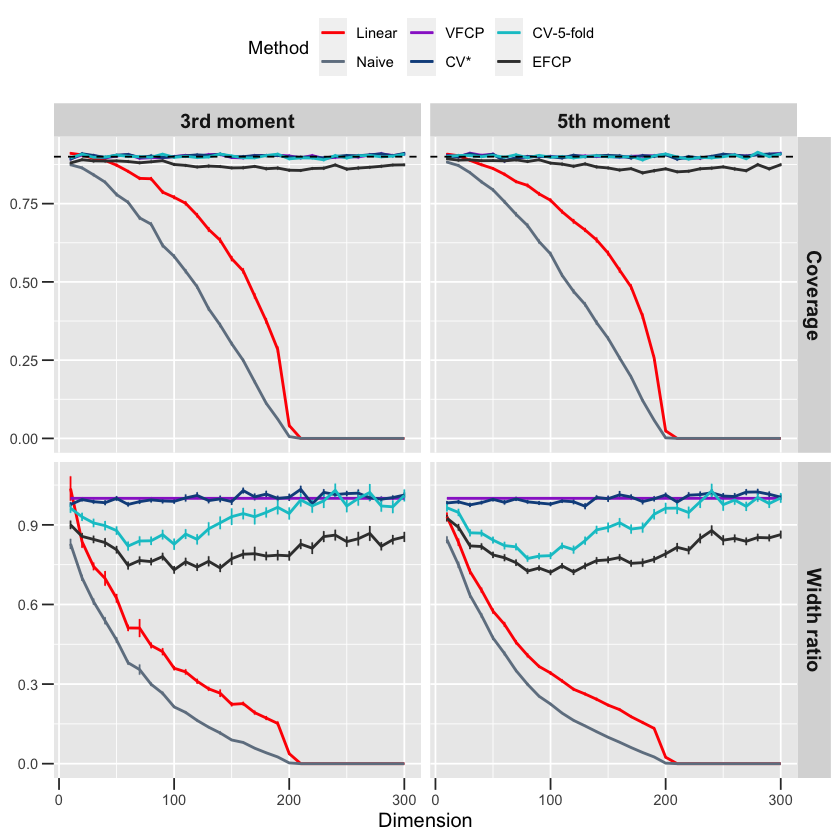

In [10]:
data_linear_fm=rbind(cov,len)
dummy_coverage <- data.frame(Var=c("Coverage"),Z= 0.9)

ggplot_linear_fm=ggplot(data=data_linear_fm, aes(x=V1, y=V2, group=Method,color=Method)) +
  geom_errorbar(aes(ymin=V2-sd, ymax=V2+sd), width=.1)+
  geom_line(size = 0.8, aes(color=Method))+  #,linetype=Method)) +
  #geom_point(size=5, colour=bgnd)+
  #geom_point(aes(shape=Method,color=Method)) +
  theme(#axis.text.y = element_blank(), 
    #axis.ticks.y = element_blank(), 
    axis.title.y = element_blank(),
    #plot.title = element_text(size = 8,hjust=0.5),
    #axis.text = element_text(size = 10),
    #axis.title =element_text(size = 10),
    legend.position="top") +
  facet_grid(Var~Moment,scales = "free")+
  #scale_shape_manual(values=shape_manual) + 
  scale_color_manual(values=colors_manual) +
  #ylim(0,1.2) + #xlab("dim") + ylab("Avg-Len")  
  xlab("Dimension")+guides(shape=FALSE)+
  theme(strip.text.x = element_text(size = 12, face = "bold"), strip.text.y = element_text(size=12, face="bold"), axis.ticks.length=unit(.25, "cm"),axis.title=element_text(size=12))+ geom_hline(data=dummy_coverage, aes(yintercept=Z), linetype="dashed")
ggsave(("ggplot_linear_fm.pdf"),ggplot_linear_fm, width = 10, height = 10, units = "in")


ggplot_linear_fm

Next we consider a nonlinear model where each row of  $X$ is generated independently following a multivariate student distribution $t_d(\nu, \Sigma)$ with $d \times d$ covariance matrix $\Sigma$ satisfying $\Sigma_{ij}=0.5$ if $i \neq j$ (equi correlation) and $\Sigma_{jj}=1$.
$Y$ is generated from 

\begin{align}
Y \sim \mathrm{Pois}\left(\sin ^{2}(X_1)+\cos^4(X_2)+0.01\right)+0.03 X_1 \epsilon_{1}+25 {1}_{\{u<0.01\}} \epsilon_{2}, \label{eq:nonlinear_pois_fm}\tag{2}
\end{align}

and each noise component of $\epsilon_k, k=1,2$, follows $t(\nu) \times (1+ \sqrt{ X_1^{2k}+X_2^{2k}})$ independently. Note that irrespective of the dimension $d$, the conditional distribution of the response only depends on the first two covariates. Similar to the linear case, we consider the degrees of freedom of $\nu=3$ in the first experiment and $\nu=5$ in the second one.

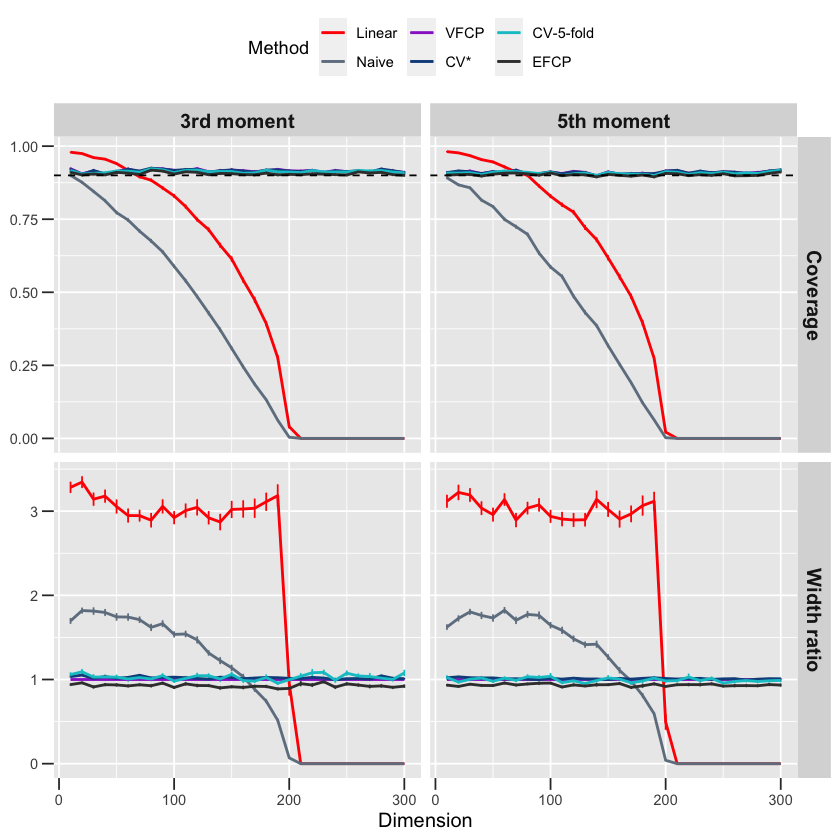

In [11]:
library(ggplot2)
load("ridge_nonlinear_cov100_t3.RData")
load("ridge_nonlinear_len100_t3.RData")

len.param = len.param/len.vfcp
len.naive = len.naive/len.vfcp
len.star = len.star/len.vfcp
len.cv5 = len.cv5/len.vfcp
len.efcp = len.efcp/len.vfcp
len.vfcp = len.vfcp/len.vfcp


df.cov3=data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))
df.cov3_sd=data.frame(dim,apply(cov.param,2,sd),apply(cov.naive,2,sd),apply(cov.vfcp,2,sd),apply(cov.star,2,sd),apply(cov.cv5,2,sd), apply(cov.efcp,2,sd))/sqrt(nrow(len.param))


df.len3=data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))
df.len3_sd=data.frame(dim,apply(len.param,2,sd),apply(len.naive,2,sd),apply(len.vfcp,2,sd),apply(len.star,2,sd),apply(len.cv5,2,sd), apply(len.efcp,2,sd))/sqrt(nrow(len.param))


load("ridge_nonlinear_cov100_t5.RData")
load("ridge_nonlinear_len100_t5.RData")

len.param = len.param/len.vfcp
len.naive = len.naive/len.vfcp
len.star = len.star/len.vfcp
len.cv5 = len.cv5/len.vfcp
len.efcp = len.efcp/len.vfcp
len.vfcp = len.vfcp/len.vfcp

df.cov5=data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))
df.cov5_sd=data.frame(dim,apply(cov.param,2,sd),apply(cov.naive,2,sd),apply(cov.vfcp,2,sd),apply(cov.star,2,sd),apply(cov.cv5,2,sd), apply(cov.efcp,2,sd))/sqrt(nrow(len.param))

df.len5=data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))
df.len5_sd=data.frame(dim,apply(len.param,2,sd),apply(len.naive,2,sd),apply(len.vfcp,2,sd),apply(len.star,2,sd),apply(len.cv5,2,sd), apply(len.efcp,2,sd))/sqrt(nrow(len.param))


bgnd <- theme_get()$panel.background$fill
names=c("Linear","Naive","VFCP","CV*","CV-5-fold","EFCP")
#colors_manual=c("blue","#FF9933","#999000","66FFCC","#66CC99","#9999FF","#FF00CC")
colors_manual=c("red","slategrey","darkorchid3","dodgerblue4","turquoise3","grey23")

shape_manual=c(0,1,2,3,4,5)

seq=seq(2,60,by=2)


df.cov = rbind(df.cov3[seq,], df.cov5[seq,])
df.cov_sd = rbind(df.cov3_sd[seq,], df.cov5_sd[seq,])
df.len = rbind(df.len3[seq,], df.len5[seq,])
df.len_sd = rbind(df.len3_sd[seq,], df.len5_sd[seq,])

Moment = c("3rd moment", "5th moment")
df_names = expand.grid(seq,Moment,names)

cov_vec = as.vector(as.matrix(df.cov[,-1]))
cov_sd_vec = as.vector(as.matrix(df.cov_sd[,-1]))
cov = cbind(df_names[,1]*5, cov_vec, cov_sd_vec , df_names[,-1] ) 


len_vec = as.vector(as.matrix(df.len[,-1]))
len_sd_vec = as.vector(as.matrix(df.len_sd[,-1]))
len = cbind(df_names[,1]*5, len_vec, len_sd_vec , df_names[,-1]) 

cov$Var="Coverage"
len$Var = "Width ratio"

colnames(cov) = c("V1","V2","sd","Moment","Method","Var")
colnames(len) = c("V1","V2","sd","Moment","Method","Var")

data_nonlinear_fm=rbind(cov,len)
dummy_coverage <- data.frame(Var=c("Coverage"),Z= 0.9)

ggplot_nonlinear_fm=ggplot(data=data_nonlinear_fm, aes(x=V1, y=V2, group=Method,color=Method)) +
  geom_errorbar(aes(ymin=V2-sd, ymax=V2+sd), width=.1)+
  geom_line(size = 0.8, aes(color=Method))+  #,linetype=Method)) +
  #geom_point(size=5, colour=bgnd)+
  #geom_point(aes(shape=Method,color=Method)) +
  theme(#axis.text.y = element_blank(), 
    #axis.ticks.y = element_blank(), 
    axis.title.y = element_blank(),
    #plot.title = element_text(size = 8,hjust=0.5),
    #axis.text = element_text(size = 10),
    #axis.title =element_text(size = 10),
    legend.position="top") +
  facet_grid(Var~Moment,scales = "free")+
  #scale_shape_manual(values=shape_manual) + 
  scale_color_manual(values=colors_manual) +
  #ylim(0,1.2) + #xlab("dim") + ylab("Avg-Len")  
  xlab("Dimension")+guides(shape=FALSE)+
  theme(strip.text.x = element_text(size = 12, face = "bold"), strip.text.y = element_text(size=12, face="bold"), axis.ticks.length=unit(.25, "cm"),axis.title=element_text(size=12))+ geom_hline(data=dummy_coverage, aes(yintercept=Z), linetype="dashed")
ggsave(("ggplot_nonlinear_fm.pdf"),ggplot_nonlinear_fm, width = 10, height = 10, units = "in")


ggplot_nonlinear_fm

The two plots above show the mean coverage and mean width ratio of EFCP, VFCP, a naive method, a linear parametric method and two cross-validation methods over 100 independent trials. (For details of these methods please refer back to our paper.) The $x$-axis shows the dimension $d$ of the model changing from $10$ to $300$ while the total sample size is fixed at $N=200$. The second row of the plot "Width ratio" shows the ratio of the width of each method prediction interval to that of the VFCP's prediction interval. The standard error of coverage and width ratio is also shown as a fluctuation around each point. Given the large number of replications, the standard error is too small for most methods except for Linear. In all the models, the covariates and errors are heavy-tailed. EFCP, VFCP  and the two cross validation methods attain validity while Naive and Linear under cover the true response as expected.

We notice a few interesting points
- VFCP has valid coverage (near perfect at $0.9$), while EFCP slightly undercovers attaining at worst coverage of $0.88$ across all dimensions. For smaller dimensions $(\le 100)$, the coverage of EFCP is also near perfect. Neither the Linear nor the Naive methods give valid coverage, and this is expected because the two settings are both heteroskedastic. Further, the coverage for these methods drop significantly as dimension increases.  
- When $d \geq N$, we note that the Linear method and the Naive method prediction will always have zero length intervals since all $N$ residuals will be equal to zero. Consequently, in such a situation, these two methods will have coverage equal to zero.
- Compared with VFCP, EFCP has an improved efficiency resulting in 10--30\% smaller widths across the dimensions. On average, EFCP improves the width of VFCP by 20\%. 
- Before computing the ratio of the widths, we find that the standard error of the widths of EFCP is, on average, 30\% smaller than that of VFCP over 100 repetitions.